# Stochastic Personal Finance Forecasting Simulator 
<b>Author:</b> Tyler Bikaun<br>
<b>Last Modified:</b> 14.03.2020

><b>Purpose:</b> Develop a user simulator based on object oriented design principles for use in stochastic personal financial forecasting.

<b>Modules Included</b>
<ol>
    <li>Asset Value</li>
    <li>Superannuation</li>
    <li>Tax</li>
    <li>Savings</li>
    <li>Expenses</li>
    <li>Income</li>
    <li>Loan</li>
    <li>Profile</li>
    <li>Simulation</li>
</ol>

><b>Inheritance:</b> 1:Asset Value to 7:Loan -> 8:Profile -> 9:Simulation

### Notebook set-up and importation of libraries

In [1]:
import datetime
from dateutil.relativedelta import relativedelta
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Initialisation of Logging

In [2]:
import logging
logging.basicConfig(filename='simulation.log', level=logging.DEBUG)

### Initialisation of Classes

><b>Asset Value:</b> The AssetValue class is used for approximating user asset value and wealth. This is initially used for modeling real estate property value. This model currently assumes that the asset value only appreciates at a given rate (asset return rate).<br><br>
Future model considerations:<ol><li>Integrate stochastic asset return rate... or damages to the market structure?</li></ol>

In [3]:
class AssetValue():
    """
    Model for approximating asset value and wealth.
    Initially used for property value
    """
    
    def __init__(self, assetReturnRate):
        self.assetReturnRate = assetReturnRate / 12
        
    def getAssetValue(self, assetPrincipal, compoundPeriod):
        # calculates asset value on a periodic compounding per month
        assetValue = assetPrincipal * (1 + self.assetReturnRate)**compoundPeriod
        return assetValue

><b>Superunnuation:</b> The Superunnuation class is used for capturing superannuation acquisition over time. Factors that are integrated into this class include: 1. super contributions (monthly freq), 2. initial balance, 3. rate of return, 4. employer contribution rate, 5. fees (administration and investment), 6. insurance premiums, and 7. indireect costs that aren't captured within these buckets.

In [4]:
class Superannuation():
    """
    Note: Assumes superannuation is run via an institution and is not self managed.
    
    """
    
    def __init__(self, contribRate):
        self.superContrib = 0
        self.superInitialBal = 1000   # initial super balance
        self.superReturnRate = 0.06 / 12
        
        self.contribRate = contribRate   # Employer contribution rate
        
        # Cumulative Sum of Super Balance and Value
        self.superBalCumSum = 0
        self.superValCumSum = 0
        
    def superFees(self, phase):
        if phase == 1:
            # phase 1 - before retirement
            self.contribFee = 1/12
        if phase == 2:
            # phase 2 - retirement
            self.contribFee = 0
        self.adminFee = 100
        self.investmentFee = 1/12
        self.insurancePrem = 1/12
        self.indirectCosts = 0.2/12
        self.superFeesTotal = 0
        
        self.superFeesTotal = self.adminFee + self.investmentFee * self.superContrib + \
                            self.contribFee * self.superContrib + self.insurancePrem * self.superContrib + \
                            self.indirectCosts * self.superContrib
#         print(f'Super Fees: ${self.superFeesTotal:0.2f}')
        
    def superValue(self, phase):
        
        if self.superBalCumSum == 0:
#             print('adding initial value to superVal')
            self.superValCumSum += self.superContrib + self.superInitialBal
        elif phase == 1:
#             print(f'{self.superValCumSum}-{self.superContrib}-{self.superFeesTotal}-{1 + self.superReturnRate}')
            self.superValCumSum = (self.superValCumSum + self.superContrib - self.superFeesTotal) * (1 + self.superReturnRate)
        elif phase == 2:
            self.superValCumSum = (self.superValCumSum - self.drawdownAmt - self.superFeesTotal) * (1 + self.superReturnRate)
        
#         print(f'Super Value: ${self.superValCumSum:0.2f}')
        
        
    def superBalance(self):
        
        if self.superBalCumSum == 0:
#             print('adding initial value to superBal')
            self.superBalCumSum += self.superContrib + self.superInitialBal
        else:
            self.superBalCumSum += self.superContrib - self.superFeesTotal
        
#         print(f'Super Balance: ${self.superBalCumSum:0.2f}')
        
    def superContribution(self, phase, income):
        # Monthly income...
        self.superContrib = self.contribRate * income
#         print(f'Super Contribution: ${self.superContrib:0.2f}')
        
        self.superFees(phase)
        self.superValue(phase)
        self.superBalance()
        
        
    def superDrawDown(self):
        # Drawdown once retirement starts and contributions cease
        retirementIncome = 25000
        self.drawdownAmt = retirementIncome / 12
        
        self.superContribution(2, 0)   # no income within phase 2
        
        

><b>Tax:</b> The Tax class is used to calculate payable tax on taxable income in accordance with tax rates set by the Australian Tax Office (ATO).

In [5]:
class Tax():
    """
    Model for taxing income.
    Calculates tax on gross annual income.
    Note: Tax rates are current as of 2019-2020 and sourced from the ATO.
    """
    
    def __init__(self):
        self.tax_table_income = {1: [0, 18200],
                    2: [18201, 37000],
                    3: [37001, 90000],
                    4: [90001, 180000],
                    5: [180001, 1000000000]}   # ridiculous upper limit

        self.tax_table_paymt = {1: [0, 0],
                        2: [0.19, 0],
                        3: [0.325, 3572],
                        4: [0.37, 20797],
                        5: [0.45, 54097]}
    
    def getTaxAmount(self, income):
        
        income = income * 12 # input is per month...
        
        for key, value in self.tax_table_income.items():
            if value[0] <= income <= value[1]:
                tax_to_pay = self.tax_table_paymt[key][1] + self.tax_table_paymt[key][0] * \
                (income - self.tax_table_income[key][0])
                
        monthlyIncomeTax = tax_to_pay / 12
        
        return monthlyIncomeTax

><b>Savings:</b> The Savings class is used for capturing user savings based on proportions saved which vary over time. Savings also work as a buffer for rare events that cannot be directly covered by income.

In [6]:
class Savings():
    """
    Model for savings.
    """
    
    def __init__(self, proportionSaved):
        """
        
        """
        self.proportionSaved = proportionSaved
        
        # data capture
        self.dataHistory = []
        self.savingHistory = []
        
    def getSavedAmount(self, remainingIncome):
        """
        Gets amount saved from remainingIncome
        """
        if remainingIncome > 0:
            return remainingIncome*self.proportionSaved
        else: 
            return 0
        
    # Data Capture Functions
    def getSavingHistory(self, date, savingInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.savingHistory.append(savingInfo)

><b>Expenses:</b> The Expenses class is used to capture expenses relating to life in general. This is currently modelled as being stochastic within certain limits based on living costs.

In [7]:
class Expenses():
    """
    Model for general expenses.
    """
    
    def __init__(self, expenses):
        """
        
        """
        
        # Everything is on a monthly basis in the model...
        self.expenses = expenses
        
    def increaseExpenseRandomly(self, phase):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """

        expensesTemp = 0
        if (0.5 < np.random.uniform(0,1)):
            if phase == 2:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses / 2)
            else:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses)
            
#             print(f'Expense balance: ${increaseAmt:0.2f}')
            return increaseAmt
        else:
#             print(f'Expenses remain unchanged at: ${self.expenses:0.2f}', )
            if phase == 2:
                return self.expenses / 2
            else:
                return self.expenses

><b>Income:</b> The Income class is used for generating cash flow for users. Income is determined by three means (as defined by various financial institutions): 1. earned, 2. passive, and 3. portfolio.

In [8]:
class Income():
    """
    Model for income (earned, passive, portfolio).
    """
    
    def __init__(self, income):
        """
        
        """
        
        # Everything is on a monthly basis in the model...
        self.income = income
        self.remainingIncome = self.income    # init
        self.dateHistory = []
        self.incomeHistory = []

        
    def incomeAfterCosts(self, loanPaymentSum):
        """
        Aggregated Monthly.
        """
        costs = loanPaymentSum
        self.remainingIncome = self.income - costs
        
    def getIncomeHistory(self, date, incomeInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.incomeHistory.append(incomeInfo)

><b>Loan:</b> The Loan class captures loans and their attributes. Attributes include: 1. principal, 2. interest rate, 3. annual payments, 4. duration, and 5. startdate. Loans are an important factor in user simulation as they can be stackable (have more than one at a time).

In [9]:
class Loan():
    """
    Model for user profile loans.
    """
    
    def __init__(self, loanID, principal, interestRate, annualPayments, duration, startDate, loanPaymentExtra):
        self.principal = principal
        self.interestRate = interestRate
        self.annualPayments = annualPayments
        self.duration = duration
        self.startDate = datetime.datetime.strptime(startDate, '%d-%m-%Y').date()
        self.loanID = loanID
        self.period = 1
        self.endDate = (self.startDate + relativedelta(years=self.duration))
        self.beginBalance = self.principal
        self.endBalance = self.principal
        self.loanPaidOff = False
        self.loanPaidOffDate = 'Not paid off - Active'
        self.loanActive = False
        self.loanPaymentExtra = loanPaymentExtra
        self.loanPaymentMinimum = -round(np.pmt(self.interestRate/self.annualPayments, self.duration*self.annualPayments, self.principal), 2)
        
        # First loan payment amount
        # Note: loanPaymentExtra is a nominal payment that is added to the minimum loan service amount.
        self.loanPayment = self.loanPaymentExtra + self.loanPaymentMinimum
            
        # For data capture
        self.dateHistory = []
        self.loanHistory = []
    
    def initDesc(self):
        return f'''Loan {self.loanID} has principal of ${self.principal} over duration {self.duration} years with expected finish date of {self.endDate} - remaining balance: ${self.endBalance} - Minimum payment amount: ${self.loanPaymentMinimum}'''
    
    # Main Functions
    def makePayment(self):
        """
        Make a payment against the principal.
        """
        self.loanActive = True
        self.interest = round(((self.interestRate/self.annualPayments) * self.beginBalance), 2)
        self.loanPayment = min(self.loanPayment, self.beginBalance + self.interest)
        self.endBalance = self.beginBalance - (self.loanPayment - self.interest)
        self.period += 1
        self.beginBalance = self.endBalance
        
    def paymentSummary(self):
        try:
            print(f'Period: {self.period} BeginBalance: {self.beginBalance:0.2f} Principal: {self.principal:0.2f} Interest: {self.interest:0.2f} Payment: {self.loanPayment:0.2f}')
        except:
            print('Not enough information. Loan has likely not become active.')

    def loanFinished(self, date):
        """
        Used when a loan is finished.
        """
        #TODO: Add date for when loan finishes... as this may not be constant...
        self.loanPaidOff = True
        self.loanActive = False
        self.loanPaidOffDate = date
    
    # Misc Functions
    def increasePrincipal(self, increaseAmt):
        """
        Increase the amount of loan principal via month begin balance.
        """
        self.beginBalance += increaseAmt
        
    def increasePrincipalRandomly(self):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """
        if (0.99 < np.random.uniform(0,1)) and self.loanActive:
            if self.loanPaidOff == False:
                increaseAmt = np.random.randint(0,10)*1000
                self.beginBalance += increaseAmt
#                 print(f'Increased {self.loanID} balance by ${increaseAmt}')
        
    # Data Capture Functions
    def getLoanHistory(self, date, loanInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.loanHistory.append(loanInfo)

><b>Profile:</b> The Profile class is for generating user profiles. A user profile can have the previously defined classes attributed to it e.g. income, expenses, savings, tax, superannuations, and asset value. A user profile is simulated over a lifetime, the lifetime is split into two phases 1. working, and 2. retirement. In the first phase, working, the user typically would take out loans, have income, commit to superannuation, etc. In the second phase, retirement, the income streams change, superannuation starts to be drawn down, etc. Parameters of the user profile include 1. name, 2. age, 3. expected retirement age (will be an output rather than an input in the future), and 4. expected age of death (assumed from health statistics based on gender; could be extended based on other salient factors).

In [10]:
class Profile(Income, Expenses, Savings, Tax, Superannuation, AssetValue):
    """
    Profile for user. Contains their general information and meta data for financial modeling.
    """
    
    # Initializer / Instance Attributes
    def __init__(self, name, age, retireAge, deadAge, incomePA, expensesPM, proportionSaved):
        self.name = name
        self.age = age
        self.retireAge = retireAge
        self.deadAge = deadAge
        
        # Loans
        self.hasLoan = False
        self.loanDict = {}
        self.noLoans = 0
        self.loanPaymentSum = 0
        
        # Income
        self.hasIncome = False
        self.incomePA = incomePA
        self.income = self.incomePA / 12
        self.hasIncome = True
        
        # Expenses
        self.expenses = expensesPM    # Expenses per month
        
        # Savings
        self.proportionSaved = proportionSaved

        
        # Inherit Loan init.. by inheriting this class, we can access it's attributes and methods...
        Income.__init__(self, self.income)  # pass attribute to class
        
        # Init Expenses
        Expenses.__init__(self, self.expenses)
        
        
        # Init Savings
        Savings.__init__(self, self.proportionSaved)
        
        # Init Tax
        Tax.__init__(self)
        
        # init super
        Superannuation.__init__(self, 0.095)
        
        # init asset value
        AssetValue.__init__(self, 0.06)
        
        
    # Profile
    def ageStep(self, year):
        """
        Used to age the users profile and step through time.
        """
        self.age += year
    
    def summary(self):
        print(f'{self.name} is {self.age} years old and has an income of ${self.income:0.2f} per month.\n')
    
    # Loan
    def getLoan(self, principal, interestRate, annualPayments, duration, startDate, loanPaymentExtra):
        """
        Allocates a loan to the profile.
        """
        
        self.hasLoan = True
        self.noLoans += 1
#         print(f'Number of loans: {self.noLoans}')
        loanID = str(self.noLoans)
        self.loanDict[loanID] = Loan(loanID, principal, interestRate, annualPayments, duration, startDate, loanPaymentExtra)
        
    def removeLoan(self, loanID):
        """
        Removes a loan from the profile. TODO: update to remove once paid off.
        """
        try:
            del self.loanDict[loanID]
        except:
            print('Loan doesnt exist')
            
    def loanDesc(self):
        """
        Summary of active loans.
        """
        self.currentLoans = len(self.loanDict)
        try:
            return f'Current active loans for {self.name}: {self.currentLoans}'
        except:
            return f'{self.name} has no loan'
        
    def loanInfo(self):
        """
        Detailed description of loan dict. For debugging purposes.
        """
        for loanID, loanDetails in self.loanDict.items():
            print(f'{loanDetails.initDesc()}')

><b>Simulation:</b> The simulation class is used for simulating user lifetimes for stochastic modeling and analysis.

In [56]:
class Simulation(Profile):
    """
    Simulation class. Used for simulation functions and data capture.
    """
        
    def init_user_profile(self):
        """
        Initialises a user profile for simulation.
        """
        
        # Initialise Profile class
        self.userProfile = Profile(self.name, self.age, self.retireAge, self.deadAge, self.incomePA, self.expenses, self.proportionSaved)

        # Initialise loans and attribute them to the user profile
        # Loan 1 - mortgage
        self.userProfile.getLoan(principal=300000,interestRate=0.04,annualPayments=12,duration=25,startDate='1-1-2021', loanPaymentExtra=0)
        # Loan 2 - car
        self.userProfile.getLoan(principal=50000,interestRate=0.12,annualPayments=12,duration=5,startDate='01-01-2025', loanPaymentExtra=50)
        # Loan 3 - car 2
        self.userProfile.getLoan(principal=7000,interestRate=0.08,annualPayments=12,duration=10,startDate='01-06-2027', loanPaymentExtra=250)
        
    
    def __init__(self, name, age, retireAge, deadAge, incomePA, expensesPM, proportionSaved):
        """
        Intialisation of the simulation model
        """
        
        # Init Profile
        Profile.__init__(self, name, age, retireAge, deadAge, incomePA, expensesPM, proportionSaved)
        # Initialise profile for simulation
        self.init_user_profile()
    
    
    def simulate_one_step(self):
        """
        Simulates the financial situation of a user for one month.
        """
        # Duration of simulation (phase 1)
        dateStart = datetime.date(2020,1,1)
        dateStartTemp = dateStart

        # Iterate over life with month level granularity
        # Phase One - Working life
        logging.info('ENTERING PHASE ONE')

        while self.userProfile.age < self.userProfile.retireAge:
            # Current datetime of step
            logging.debug(f'Current DateTime: {dateStartTemp}')
            logging.debug(f'Monthly Income: ${self.userProfile.income:0.2f}')

            # Tax
            # Get taxable amount from income
            tax = self.userProfile.getTaxAmount(self.userProfile.income)
            logging.debug(f'Tax: ${tax:0.2f}')

            # Super
            # Contribute to superannuation from income
            self.userProfile.superContribution(1, self.userProfile.income)

            tempLoanCost = 0

            # Pay debts
            # An aggregation of loan costs is computed here over all active loans
            for loanID, loanInfo in self.userProfile.loanDict.items():    # Iterate through loans associated to the profile

                # If the start date of the loan of interest is before the current time stamp, calculate loan payment or make loan inactive if it's finished.
                if self.userProfile.loanDict[loanID].startDate <= dateStartTemp:

                    # TESTING: This step is currently simulating random increases to loan principal.
                    # This is used to emulate when income goes below zero and loans need to be increased to make up the difference.
                    # This only works if there are active loans, if no loan is active then another method for re-activating or creating a new loan need to be developed.
                    # NEED TO CONFIRM THAT THIS ISNT ATTRIBUTING EXTRA PRINCIPAL TO ALL LOANS... ONE MAY BE ENOUGH.
                    self.userProfile.loanDict[loanID].increasePrincipalRandomly()

                    # If balance remains on loans - make payment
                    if 0 < self.userProfile.loanDict[loanID].beginBalance:
                        # Raise payment against loan
                        self.userProfile.loanDict[loanID].makePayment()
                        # Print payment summary to console
#                         self.userProfile.loanDict[loanID].paymentSummary()    # shows summary of loan to console

                        # Capture loan history information for future analytics
                        self.userProfile.loanDict[loanID].getLoanHistory(dateStartTemp, self.userProfile.loanDict[loanID].beginBalance)

                        # If the loan payment makes the balance zero, make the loan in-active as it's paid off
                        if self.userProfile.loanDict[loanID].beginBalance == 0:
                            logging.debug(f'LOAN {loanID} PAID OFF!')
                            # Set loanFinished to True
                            self.userProfile.loanDict[loanID].loanFinished(dateStartTemp)

                        # Loan is not paid off but persists for the next period
                        else:
                            # Capture loanPayment for totalcost aggregation
#                             self.userProfile.loanDict[loanID].paymentSummary()    # shows summary of loan to console
                            
    #                         print(f'Loan {loanID} - Begin Balance: ${self.userProfile.loanDict[loanID].beginBalance:0.2f} Payment: {self.userProfile.loanDict[loanID].loanPayment:0.2f}')
    #                         logging.debug(f'Loan {loanID} - Begin Balance: ${self.userProfile.loanDict[loanID].beginBalance:0.2f} Payment: {self.userProfile.loanDict[loanID].loanPayment:0.2f}')
                            tempLoanCost += self.userProfile.loanDict[loanID].loanPayment

                    # No principal - either loan hasnt begun or its finished
                    else:
                        self.userProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)

                # Too early - no loans are active
                else:
                    self.userProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)
                    pass

            # Expenses
            # Currently randomly increasing expenses to emulate randomness
            # This has logic based on the phase of the user and some other salient information
            expenses =  self.userProfile.increaseExpenseRandomly(1)

            # Calculate income remaining after costs attributed to tax, expenses, etc.
            self.userProfile.incomeAfterCosts(tax + tempLoanCost + expenses)
            logging.debug(f'Income Remaining: ${self.userProfile.remainingIncome:0.2f}')
            # Capture income history for future analysis
            self.userProfile.getIncomeHistory(dateStartTemp, self.userProfile.remainingIncome)

            # Savings
            # Calculate savings based on remaining income (can't save what you don't have)
            savedAmt = self.userProfile.getSavedAmount(self.userProfile.remainingIncome)
            logging.debug(f'Amount saved this month: ${savedAmt:0.2f}')

            # Note: if more draw downs occur on the remaining income, then the savings need to be subtracted explicitly aswell.
            # As this is not the case, it doesn't matter that the savings amount isn't removed from this parameter.


            # Asset value
            # Compute asset value based on compounding period and interest rates 
    #         self.userProfile.getAssetValue(self.userProfile, compoundPeriod)

            # Create an ordered dictionary of information
            yield OrderedDict([('Date', dateStartTemp),
                              ('Income', self.userProfile.income),
                              ('Tax', self.userProfile.getTaxAmount(self.userProfile.income)),
                              ('SuperContrib', self.userProfile.superContrib),
                               ('SuperBalance', self.userProfile.superBalCumSum),
                               ('SuperValue', self.userProfile.superValCumSum),
                              ('LoanDebt', tempLoanCost),
                              ('Expenses', expenses),
                              ('RemainingIncome', self.userProfile.remainingIncome),
                              ('SavedAmt', savedAmt)])

            # Steps through time another month
            dateStartTemp += relativedelta(months=1)

            # if the current month of the year is January and we're not on the first year of the simulation
            # Add another year to the users profile, e.g. age them another year.
            if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
                self.userProfile.ageStep(1)

        # Iterate over life with month level granularity
        # Phase Two - Retirement
        logging.info('ENTERING PHASE TWO')

        # While the users age is less than the age of death, run the simulation
        while self.userProfile.age < self.userProfile.deadAge:
            logging.debug(f'Current DateTime: {dateStartTemp}')

            # Super drawdown
            # Draw down super as this will act as a source of income
            # Need to review how this is used...
            self.userProfile.superDrawDown()

            # Expenses
            # Expenses in the retirement phase are treated differently to the 
            # working life phase
            expenses =  self.userProfile.increaseExpenseRandomly(2)

            # Create an ordered dictionary of information
            yield OrderedDict([('Date', dateStartTemp),
                              ('Income', 0),
                              ('Tax', 0),
                              ('SuperContrib', 0),
                              ('SuperBalance', self.userProfile.superBalCumSum),
                              ('SuperValue', self.userProfile.superValCumSum),
                              ('LoanDebt', 0),
                              ('Expenses', expenses),
                              ('RemainingIncome', 0),
                              ('SavedAmt', 0)])

            # Steps through time another month
            dateStartTemp += relativedelta(months=1)

            # if the current month of the year is January and we're not on the first year of the simulation
            # Add another year to the users profile, e.g. age them another year.
            if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
                self.userProfile.ageStep(1)
                
                
    def simulate(self):
        """
        Simulates a users finance over their lifetime.
        """
        return pd.DataFrame(self.simulate_one_step())
        
                
    def monte_carlo_model(self, iterations):
        """
        Runs n iterations of the user life simulation and captures results for analysis.
        """
        
        self.simulationHistory = list()
        
        # Output information pertaining to to user profile summary and loan descriptions/information
        self.userProfile.summary()
        self.userProfile.loanDesc()
        self.userProfile.loanInfo()
        
        for iteration in range(1, iterations+1, 1):
            print(f'\nIteration Number: {iteration}')
            self.simulationHistory.append(self.simulate())
            
            # Need to reinitialise user profile as the profile model believes the user is dead....
            self.init_user_profile()
    

    def statistical_analysis(self):
        """
        Performs a statistical analysis of the monte carlo simulation results. 
        """
        pass
        
    

#### Testing Simulation model

In [57]:
# initialse simulation class
sim = Simulation(name='tyler',age=26,retireAge=65,deadAge=80,incomePA=52000,expensesPM=1000,proportionSaved=0.25)

In [59]:
# Run monte carlo model for two simulation iterations
df_store = sim.monte_carlo_model(5)

tyler is 26 years old and has an income of $4333.33 per month.

Loan 1 has principal of $300000 over duration 25 years with expected finish date of 2046-01-01 - remaining balance: $300000 - Minimum payment amount: $1583.51
Loan 2 has principal of $50000 over duration 5 years with expected finish date of 2030-01-01 - remaining balance: $50000 - Minimum payment amount: $1112.22
Loan 3 has principal of $7000 over duration 10 years with expected finish date of 2037-06-01 - remaining balance: $7000 - Minimum payment amount: $84.93

Iteration Number: 1

Iteration Number: 2

Iteration Number: 3

Iteration Number: 4

Iteration Number: 5


In [60]:
sim.simulationHistory[0].tail()

,Date,Income,Tax,SuperContrib,SuperBalance,SuperValue,LoanDebt,Expenses,RemainingIncome,SavedAmt
643,2073-08-01,0.0,0.0,0.0,78093.777778,322903.635097,0.0,506.873927,0.0,0.0
644,2073-09-01,0.0,0.0,0.0,77993.777778,322323.903273,0.0,500.000000,0.0,0.0
645,2073-10-01,0.0,0.0,0.0,77893.777778,321741.272789,0.0,500.000000,0.0,0.0
646,2073-11-01,0.0,0.0,0.0,77793.777778,321155.729153,0.0,500.000000,0.0,0.0
647,2073-12-01,0.0,0.0,0.0,77693.777778,320567.257799,0.0,500.000000,0.0,0.0


In [61]:
sim.simulationHistory[1].tail()

,Date,Income,Tax,SuperContrib,SuperBalance,SuperValue,LoanDebt,Expenses,RemainingIncome,SavedAmt
643,2073-08-01,0.0,0.0,0.0,78093.777778,322903.635097,0.0,536.611765,0.0,0.0
644,2073-09-01,0.0,0.0,0.0,77993.777778,322323.903273,0.0,500.000000,0.0,0.0
645,2073-10-01,0.0,0.0,0.0,77893.777778,321741.272789,0.0,504.164658,0.0,0.0
646,2073-11-01,0.0,0.0,0.0,77793.777778,321155.729153,0.0,500.000000,0.0,0.0
647,2073-12-01,0.0,0.0,0.0,77693.777778,320567.257799,0.0,482.034515,0.0,0.0


# Analytics on models...

In [73]:
# Initialise empty dataframe instance
df_analytics = pd.DataFrame()
# column counter
column_count = 1

for df in sim.simulationHistory:
    
    # Expenses
    df_analytics[f'Expenses_{column_count}'] = df['Expenses']
    
    column_count += 1
    
# do some basic statistical analysis
df_analytics['Mean'] = df_analytics.apply(lambda x: x.mean(), axis=1)
df_analytics['Q25'] = df_analytics.apply(lambda x: x.quantile(0.25), axis=1)
df_analytics['Q50'] = df_analytics.apply(lambda x: x.quantile(0.50), axis=1)
df_analytics['Q75'] = df_analytics.apply(lambda x: x.quantile(0.75), axis=1)


In [74]:
df_analytics.tail()

,Expenses_1,Expenses_2,Expenses_3,Expenses_4,Expenses_5,Mean,Q25,Q50,Q75
643,506.873927,536.611765,461.993395,500.000000,586.977491,518.491316,501.718482,506.873927,523.021428
644,500.000000,500.000000,406.780858,500.000000,455.846544,472.525480,460.016278,472.525480,500.000000
645,500.000000,504.164658,500.000000,429.421285,484.896546,483.696498,483.996510,484.896546,500.000000
646,500.000000,500.000000,561.312123,500.000000,466.415133,505.545451,500.000000,500.000000,501.386363
647,500.000000,482.034515,410.186543,427.893645,500.000000,464.022940,436.925969,464.022940,486.525886


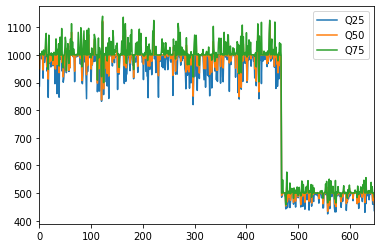

In [77]:
df_analytics[['Q25', 'Q50', 'Q75']].plot()

In [78]:
import plotly.graph_objects as go
from datetime import datetime

ModuleNotFoundError: No module named 'plotly'

# SIMULATION DEVELOPMENT

## Running Basic User Simulation

### Initialise user profile with basic information

### Simulate User Profile - 1 Lifetime

#### Simulation Iterations
Note: Simulation outputs on a monthly frequency.

## Lifetime Visualisations